# Save candidate matches and find a best global match

In [4]:
import os
import numpy as np
import tifffile
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

from DLC_for_WBFM.utils.feature_detection.feature_pipeline import *
from DLC_for_WBFM.utils.feature_detection.utils_tracklets import *
from DLC_for_WBFM.utils.feature_detection.utils_detection import *
from DLC_for_WBFM.utils.feature_detection.visualization_tracks import *
from DLC_for_WBFM.utils.video_and_data_conversion.import_video_as_array import *
import networkx as nx
from DLC_for_WBFM.utils.feature_detection.utils_reference_frames import *
import pickle


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Get the 3d bigtiff folder
bigtiff_folder = r'D:\More-stabilized-wbfm'

btf_fname_red = r'test2020-10-22_16-15-20_test4-channel-0-pco_camera1\test2020-10-22_16-15-20_test4-channel-0-pco_camera1bigtiff.btf'
btf_fname_red = os.path.join(bigtiff_folder, btf_fname_red)


In [135]:
# Same opt for both
opt = {'start_frame':0,
       'num_frames':500,
       'verbose':0,
      'save_candidate_matches':True,
       'add_affine_to_candidates':True}

p = PreprocessingSettings()
p.do_filtering=False
p.do_rigid_alignment=True
p.do_mini_max_projection=True
out = track_neurons_full_video(btf_fname_red, **opt, preprocessing_settings=p)
new_matches, new_conf, new_frames, candidates = out

  4%|███▏                                                                            | 20/499 [06:03<2:18:53, 17.40s/it]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 489/499 [2:34:43<03:01, 18.10s/it]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 490/499 [2:35:01<02:42, 18.11s/it]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 491/499 [2:35:18<02:21, 17.70s/it]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


100%|███████████████████████████████████████████████████████████████████████████████| 499/499 [2:37:43<00:00, 18.96s/it]


In [137]:
from collections import defaultdict

In [140]:
# Combine the candidate matches
bp_candidates = defaultdict(list)
for key in tqdm(new_matches):
    # Concatenate matches
    tmp_matches = defaultdict(int)
    for m_and_w in new_matches[key]:
        m = (m_and_w[0], m_and_w[1])
        # Default value of 0
        tmp_matches[m] += m_and_w[-1]
    # Convert back to list
    for k, v in tmp_matches.items():
        bp_candidates[key].append([k[0],k[1],v])

# Apply bipartite matching
bp_match_dict = {}
for key in tqdm(new_matches):
    bp_matches = calc_bipartite_matches(bp_candidates[key])
    bp_match_dict[key] = bp_matches

100%|█████████████████████████████████████████████████████████████████████████████████| 499/499 [01:07<00:00,  7.37it/s]


In [141]:
clust_df = build_tracklets_from_classes(new_frames, bp_match_dict, new_conf, verbose=0)

In [143]:
fname = 'clust_df_dat_affine-and-features.pickle'
with open(fname, 'wb') as f:
    pickle.dump(clust_df,f)
fname = 'match_dat_affine-and-features.pickle'
with open(fname, 'wb') as f:
    pickle.dump((bp_match_dict, new_conf), f)

In [144]:
fname = 'frame_dat_affine-and-features.pickle'
[frame.prep_for_pickle() for frame in new_frames]
with open(fname, 'wb') as f:
    pickle.dump(new_frames, f)

## Postprocess: stitching

In [5]:
# Stitch 
#... Recover if crashed
fname = 'clust_df_dat_affine-and-features.pickle'
with open(fname, 'rb') as f:
    clust_df = pickle.load(f)
fname = 'frame_dat_affine-and-features.pickle'
with open(fname, 'rb') as f:
    new_frames = pickle.load(f)
[f.rebuild_keypoints() for f in tqdm(new_frames)];

In [6]:
# Try to extend
df, out = stitch_tracklets(clust_df,
                     new_frames,
                     max_stitch_distance=10,
                     min_starting_tracklet_length=20,
                     minimum_match_confidence=0.4,
                     verbose=1)

  0%|                                                                                           | 0/883 [00:00<?, ?it/s]

Trying to consolidate 4813 tracklets
Note: computational time of this function is front-loaded


100%|█████████████████████████████████████████████████████████████████████████████████| 883/883 [26:49<00:00,  1.82s/it]

Extended and dropped 208/4813 rows
Finished


In [8]:
which_suffix = 'affine-and-features'
fname = f'clust_df_dat_{which_suffix}-stitched.pickle'
with open(fname, 'wb') as f:
    pickle.dump(df,f)
# fname = f'match_dat_{which_suffix}-stitched.pickle'
# with open(fname, 'wb') as f:
#     pickle.dump((bp_match_dict, new_conf), f)

## Build a graph from candidate matches

In [132]:
key = (0,1)


In [133]:
bp_matches = calc_bipartite_matches(candidates[key])
bp_match_dict = {key:bp_matches}

## Comparitive point clouds

In [134]:
candidate_lines = plot_matched_point_clouds(new_frames,
                                            candidates,
                                            key, 
                                            color=[1,0,0],
                                            actually_draw=False)[-1]
candidate_lines.translate([-0.5,0.5,0])
greedy_matched_lines = plot_matched_point_clouds(new_frames,
                                            new_matches,
                                            key, 
                                            color=[0,0,1],
                                            actually_draw=False)[-1]
greedy_matched_lines.translate([0.5,-0.5,0])
bipartite_lines_and_dots = plot_matched_point_clouds(new_frames,
                                            bp_match_dict,
                                            key, 
                                            color=[0,1,0],
                                            actually_draw=False)

In [130]:
# WITH candidates (red)
to_draw = list(bipartite_lines_and_dots)
to_draw.append(greedy_matched_lines)
to_draw.append(candidate_lines)
o3d.visualization.draw_geometries(to_draw)

In [92]:
# WITHOUT candidates
to_draw = list(bipartite_lines_and_dots)
to_draw.append(greedy_matched_lines)
o3d.visualization.draw_geometries(to_draw)

## Comparitive 2d plots

<IPython.core.display.Javascript object>


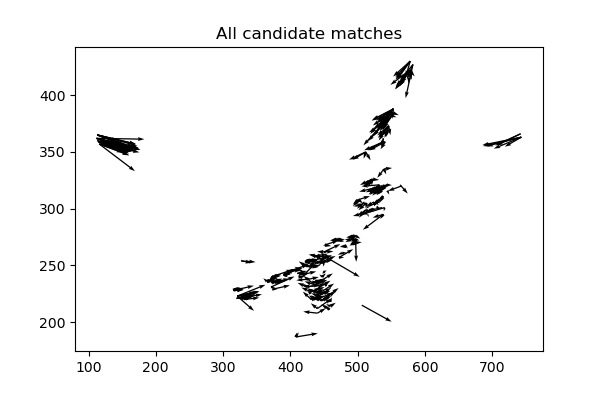

Text(0.5, 1.0, 'All candidate matches')

In [89]:
%matplotlib notebook
xyz, dat = match2quiver(new_frames, candidates, key);
plt.title("All candidate matches")

<IPython.core.display.Javascript object>


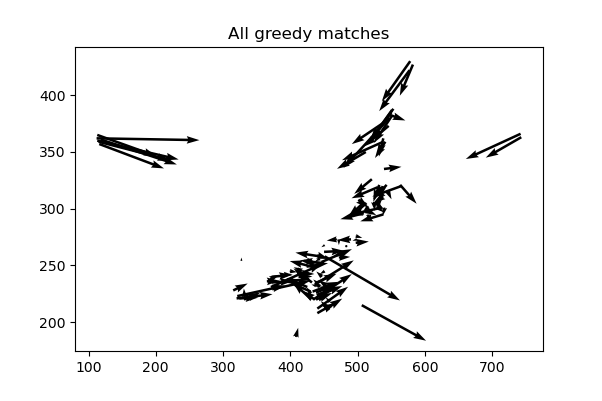

Text(0.5, 1.0, 'All greedy matches')

In [90]:
%matplotlib notebook
xyz, dat = match2quiver(new_frames, new_matches, key);
plt.title("All greedy matches")

<IPython.core.display.Javascript object>


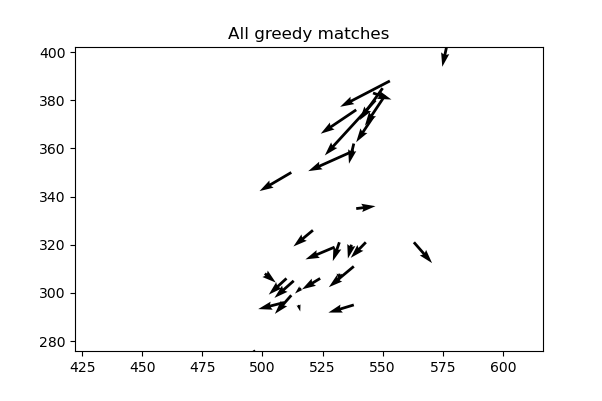

Text(0.5, 1.0, 'All greedy matches')

In [91]:
%matplotlib notebook
xyz, dat = match2quiver(new_frames, bp_match_dict, key);
plt.title("All greedy matches")

## Test if neurons remain consistent over time

In [117]:
DG_greedy = build_digraph_from_matches(new_matches, new_conf, verbose=0)

In [118]:
bp_match_dict = {}
for key in new_matches:
    bp_matches = calc_bipartite_matches(candidates[key])
    bp_match_dict[key] = bp_matches
DG_bp = build_digraph_from_matches(bp_match_dict, verbose=0)

Largest connected component size:  153
Sizes and number of components:
[2, 52]
[3, 34]
[4, 25]
[5, 14]
[6, 12]
[7, 3]
[8, 10]
[9, 9]
[10, 7]
[11, 4]
[12, 6]
[13, 5]
[14, 2]
[15, 4]
[17, 3]
[18, 4]
[19, 7]
[20, 8]
[21, 4]
[22, 4]
[23, 2]
[24, 4]
[25, 5]
[26, 1]
[27, 3]
[28, 5]
[29, 1]
[31, 2]
[32, 2]
[33, 1]
[34, 3]
[36, 2]
[37, 1]
[38, 1]
[39, 1]
[40, 2]
[42, 1]
[43, 1]
[48, 5]
[52, 1]
[53, 1]
[54, 4]
[55, 3]
[59, 1]
[63, 1]
[70, 1]
[74, 1]
[76, 2]
[77, 1]
[78, 1]
[80, 1]
[86, 1]
[107, 1]
[153, 1]


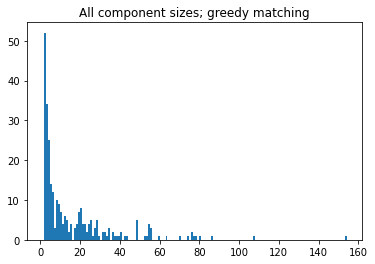

In [119]:
%matplotlib inline
thresh = 0.0

G = get_subgraph_with_strong_weights(DG_greedy, thresh)
big_G, all_sz = calc_connected_components(G, False)
plt.hist([z for z in all_sz if z > 1], bins=list(range(1,max(all_sz)+2)));
plt.title('All component sizes; greedy matching')

[vals, counts] = np.unique(all_sz, return_counts=True)
print("Sizes and number of components:")
for v, c in zip(vals, counts):
      print([v, c])

Largest connected component size:  30
Sizes and number of components:
[2, 71]
[3, 66]
[4, 38]
[5, 34]
[6, 17]
[7, 26]
[8, 31]
[9, 20]
[10, 14]
[11, 13]
[12, 14]
[13, 2]
[14, 8]
[15, 3]
[16, 2]
[17, 5]
[18, 1]
[19, 18]
[20, 31]
[21, 8]
[22, 15]
[23, 1]
[24, 10]
[25, 4]
[28, 2]
[29, 1]
[30, 12]


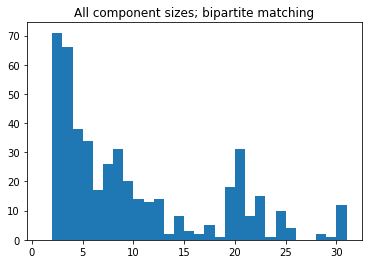

In [121]:
%matplotlib inline
thresh = 0.0

G = get_subgraph_with_strong_weights(DG_bp, thresh)
big_G, all_sz = calc_connected_components(G, False)
plt.hist([z for z in all_sz if z > 1], bins=list(range(1,max(all_sz)+2)));
plt.title('All component sizes; bipartite matching')

[vals, counts] = np.unique(all_sz, return_counts=True)
print("Sizes and number of components:")
for v, c in zip(vals, counts):
      print([v, c])